<a href="https://colab.research.google.com/github/hafizsam/KPTPACE-DLCV/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Centric Approach in Deep Learning

The advantages of becoming more data-centric are numerous, ranging from improved reporting speed and accuracy to better-informed decision-making.

To adopting a data-centric approach we need to:
- Ensure high-quality data consistency across the deep learning project lifecycle.
- Make the labels consistent.
- Use production data to get timely feedback.
- Use error analysis to focus on a subset of data.
- Eliminate the noisy samples; as discussed above more data is not always better. 

## Code Initialization

- Mount Google Collab with Google Drive to import datasets
- Import modules
- Define an object to apply torchvision.transforms to data
- Define these functions:
 - train_and_validate()
 - plot()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [34]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary
from google.colab.patches import cv2_imshow

In [5]:
# Applying Transforms to the Data
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])}

In [6]:
# Define Functions

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

def plot(history,suptitle):
  plt.figure(figsize=(9, 2.5))
  plt.suptitle(suptitle)
  history = np.array(history)
  plt.subplot(121)
  plt.plot(history[:,0:2])
  plt.legend(['Tr Loss', 'Val Loss'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  plt.ylim(0,3)
  
  plt.subplot(122)
  plt.plot(history[:,2:4])
  plt.legend(['Tr Accuracy', 'Val Accuracy'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  plt.show()

## Normal Training

Training with less-quality dataset and simple resnet model.

In [ ]:
###############################
#        Load the Data        #
###############################

# Set train and valid directory paths
train_directory = os.path.join('/content/drive/MyDrive/Deep Learning Projects/fruit_dataset/train')
test_directory = os.path.join('/content/drive/MyDrive/Deep Learning Projects/fruit_dataset/validation')

# Batch size and number of classes
batchSize = 32
num_classes = len(os.listdir(train_directory))

# Load Data from folders
data = {'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
        'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']) }

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=False)

#######################################
#          Create Dataloader          #
#######################################

# Turn train and test custom Dataset's into DataLoader's
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=batchSize, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=batchSize, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

#######################################
#             Define Model            #
#######################################

# Define CNN Model, Criterion, Optimizer and Move the Model to GPU
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model = model_ft.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [11]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.5176, Accuracy: 85.2207%, 
		Validation : Loss : 1.3268, Accuracy: 76.1610%, Time: 7.9970s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.4043, Accuracy: 87.3321%, 
		Validation : Loss : 1.1312, Accuracy: 83.9009%, Time: 5.7905s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.3305, Accuracy: 91.1708%, 
		Validation : Loss : 1.0746, Accuracy: 82.9721%, Time: 5.8530s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2941, Accuracy: 90.5950%, 
		Validation : Loss : 1.0061, Accuracy: 83.2817%, Time: 5.9097s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2648, Accuracy: 91.3628%, 
		Validation : Loss : 0.9386, Accuracy: 83.9009%, Time: 5.7815s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2414, Accuracy: 92.5144%, 
		Validation : Loss : 0.8710, Accuracy: 83.9009%, Time: 5.7850s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.2217, Accuracy: 92.8983%, 
		Validation : Loss : 0.8072, Accuracy: 83.9009%, Time: 5.7560s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.2245, Accuracy: 92.

## Custom Resnet Model Training

Training with less-quality dataset but custom resnet model.

In [ ]:
###############################
#        Load the Data        #
###############################

# Set train and valid directory paths
train_directory = os.path.join('/content/drive/MyDrive/Deep Learning Projects/fruit_dataset/train')
test_directory = os.path.join('/content/drive/MyDrive/Deep Learning Projects/fruit_dataset/validation')

# Batch size and number of classes
batchSize = 32
num_classes = len(os.listdir(train_directory))

# Load Data from folders
data = {'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
        'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']) }

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=False)

#######################################
#          Create Dataloader          #
#######################################

# Turn train and test custom Dataset's into DataLoader's
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=batchSize, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=batchSize, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

#######################################
#             Define Model            #
#######################################

# Define CNN Model, Criterion, Optimizer and Move the Model to GPU
class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        resnet18 = models.resnet18(pretrained=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        self.classifier = nn.Linear(256, 4)
        self.relu = nn.ReLU()
       
        # initialize all fc layers to xavier
        for m in self.modules():
           if isinstance(m, nn.Linear):
               torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
      output = self.features(input_imgs)
      output = output.view(input_imgs.size(0), -1) 
      #and also our new layers.
      output = self.bn1(self.relu(self.fc0(output)))
      #output = self.bn2(self.relu(self.fc1(output)))
      output = self.classifier(output)
      return output

model_ft = MyCustomResnet18()
#num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model = model_ft.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model1, history1 = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.1872, Accuracy: 56.0461%, 
		Validation : Loss : 0.6058, Accuracy: 78.9474%, Time: 5.7371s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.4989, Accuracy: 87.5240%, 
		Validation : Loss : 0.5245, Accuracy: 82.6625%, Time: 5.6885s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.4106, Accuracy: 90.4031%, 
		Validation : Loss : 0.5004, Accuracy: 80.4954%, Time: 5.8942s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.3076, Accuracy: 90.7869%, 
		Validation : Loss : 0.4554, Accuracy: 82.6625%, Time: 6.3444s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2727, Accuracy: 91.1708%, 
		Validation : Loss : 0.4153, Accuracy: 85.4489%, Time: 5.7850s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2393, Accuracy: 93.4741%, 
		Validation : Loss : 0.4276, Accuracy: 84.2105%, Time: 5.7008s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.2146, Accuracy: 93.2821%, 
		Validation : Loss : 0.3933, Accuracy: 83.9009%, Time: 5.7477s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1966, Accuracy: 92.

## Custom Resnet with Data-Centric Approach

Training with improved dataset quality and a custom resnet deep learning model.

In [ ]:
###############################
#        Load the Data        #
###############################

# Set train and valid directory paths
train_directory = os.path.join('/content/drive/MyDrive/Deep Learning Projects/improved_fruit_dataset/train')
test_directory = os.path.join('/content/drive/MyDrive/Deep Learning Projects/improved_fruit_dataset/validation')

# Batch size and number of classes
batchSize = 32
num_classes = len(os.listdir(train_directory))

# Load Data from folders
data = {'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
        'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']) }

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=False)

#######################################
#          Create Dataloader          #
#######################################

# Turn train and test custom Dataset's into DataLoader's
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=batchSize, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=batchSize, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

#######################################
#             Define Model            #
#######################################

# Define CNN Model, Criterion, Optimizer and Move the Model to GPU
class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        resnet18 = models.resnet18(pretrained=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        self.classifier = nn.Linear(256, 4)
        self.relu = nn.ReLU()
       
        # initialize all fc layers to xavier
        for m in self.modules():
           if isinstance(m, nn.Linear):
               torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
      output = self.features(input_imgs)
      output = output.view(input_imgs.size(0), -1) 
      #and also our new layers.
      output = self.bn1(self.relu(self.fc0(output)))
      #output = self.bn2(self.relu(self.fc1(output)))
      output = self.classifier(output)
      return output

model_ft1 = MyCustomResnet18()
num_ftrs = model_ft.fc.in_features
model_ft1.fc = nn.Linear(num_ftrs, num_classes)
model1 = model_ft1.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft1.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model2, history2 = train_and_validate(model1, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.0654, Accuracy: 60.1739%, 
		Validation : Loss : 0.4326, Accuracy: 86.0681%, Time: 149.3384s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.4462, Accuracy: 86.0870%, 
		Validation : Loss : 0.2327, Accuracy: 93.4985%, Time: 6.3033s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2784, Accuracy: 90.6087%, 
		Validation : Loss : 0.1997, Accuracy: 94.7368%, Time: 6.1469s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2322, Accuracy: 92.8696%, 
		Validation : Loss : 0.1918, Accuracy: 95.0464%, Time: 6.1020s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.1994, Accuracy: 93.7391%, 
		Validation : Loss : 0.1756, Accuracy: 95.6656%, Time: 6.1649s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1694, Accuracy: 94.9565%, 
		Validation : Loss : 0.1555, Accuracy: 96.2848%, Time: 6.1752s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.1889, Accuracy: 93.2174%, 
		Validation : Loss : 0.1617, Accuracy: 95.9752%, Time: 6.1895s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1806, Accuracy: 9

## Analysis

The loss and accuracy curves belows exhibit the improvement before and after the dataset being improved.

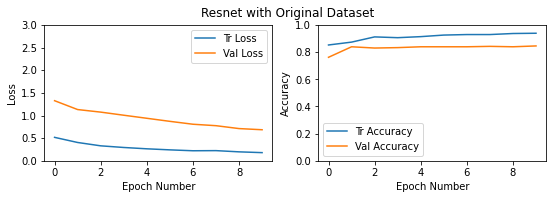

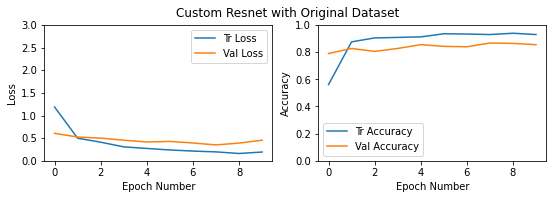

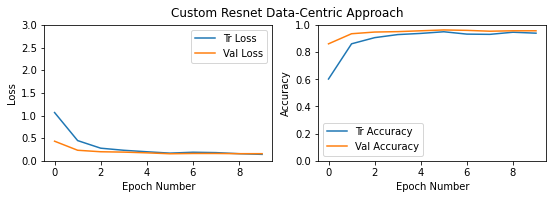

In [20]:
plot(history, "Resnet with Original Dataset")
plot(history1, "Custom Resnet with Original Dataset")
plot(history2, "Custom Resnet Data-Centric Approach")

## Inferencing with image

Inference the model using self taken images.

durian 0.9222305417060852
watermelon 0.07455246150493622
pumpkin 0.002558683278039098
tomatoes 0.0006583662470802665


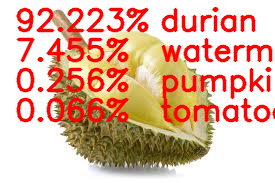

In [33]:
img = cv2.imread("/content/drive/MyDrive/Deep Learning Projects/fruit_inference_dataset/images.jpg")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([transforms.ToPILImage(),
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
 transforms.Normalize(mean = [0.485, 0.456, 0.406],
                      std =  [0.229, 0.224, 0.225]
 )])
        
img_t = transform(img)
input_batch = torch.unsqueeze(img_t, 0)
input_batch = input_batch.to(device)
trained_model2.eval()

# Carry out inference
out = trained_model2(input_batch)

classes = ['durian','pumpkin','tomatoes','watermelon']
# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the 4 categories that are predicted.
top4_prob, top4_catid = torch.topk(probabilities, 4)

for i in range(top4_prob.size(0)):
    cv2.putText(img, f"{top4_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img, f"{classes[top4_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top4_catid[i]], top4_prob[i].item())
    
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()